In [2]:
# Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [63]:
import pandas as pd

# Load training set data
X_train = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('train/y_train.txt', header=None)
subject_train = pd.read_csv('train/subject_train.txt', header=None)

# Load features and activity labels
features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['Feature_Index', 'Feature_Name'])
activity_labels = pd.read_csv('activity_labels.txt', delim_whitespace=True, header=None, names=['Activity_Index', 'Activity_Name'])

# Set column names for X_train
X_train.columns = features['Feature_Name']

# Set column name for y_train
y_train.columns = ['Activity_Index']

# Set column name for subject_train
subject_train.columns = ['Subject_ID']

# Map activity labels to their corresponding names
y_train['Activity_Name'] = y_train['Activity_Index'].map(activity_labels.set_index('Activity_Index')['Activity_Name'])

# Combine features, labels, and subject IDs
combined_train_data = pd.concat([subject_train, y_train, X_train], axis=1)

# Display the combined data
combined_train_data.drop_duplicates()


,Subject_ID,Activity_Index,Activity_Name,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,5,STANDING,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,5,STANDING,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,5,STANDING,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,5,STANDING,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,5,STANDING,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,30,2,WALKING_UPSTAIRS,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,30,2,WALKING_UPSTAIRS,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,30,2,WALKING_UPSTAIRS,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,30,2,WALKING_UPSTAIRS,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [64]:
x = combined_train_data.drop(columns=["Activity_Name"])

y = combined_train_data['Activity_Name']


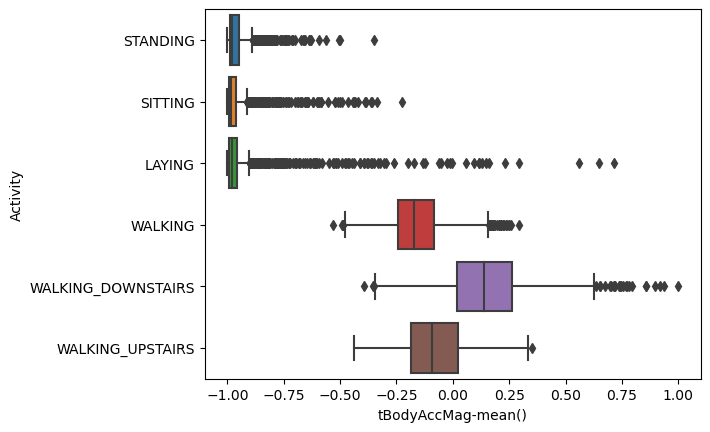

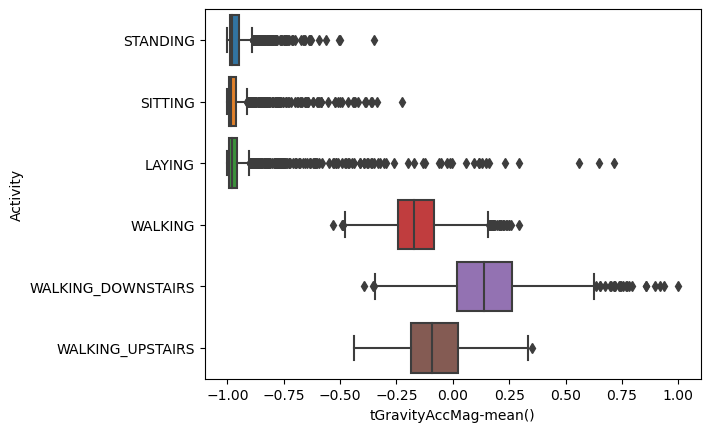

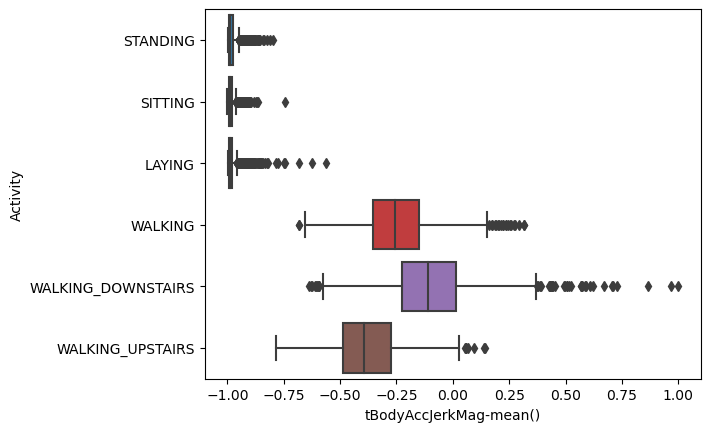

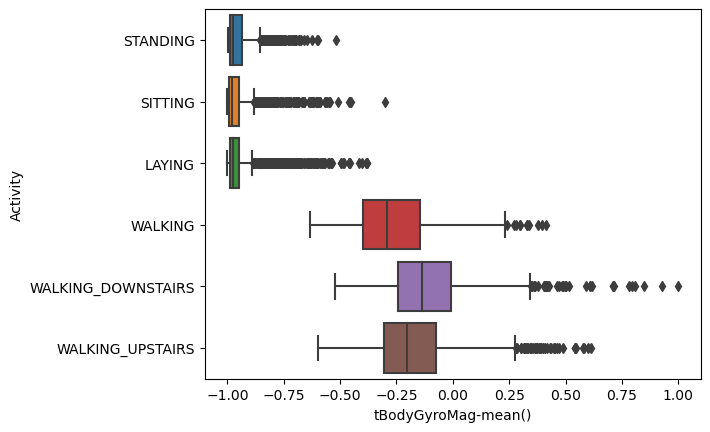

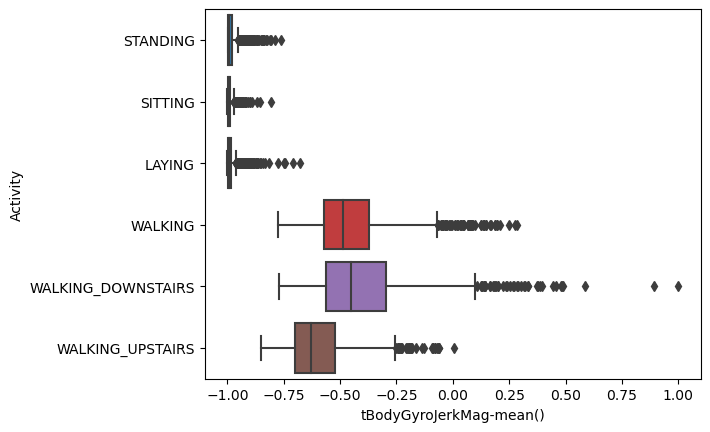

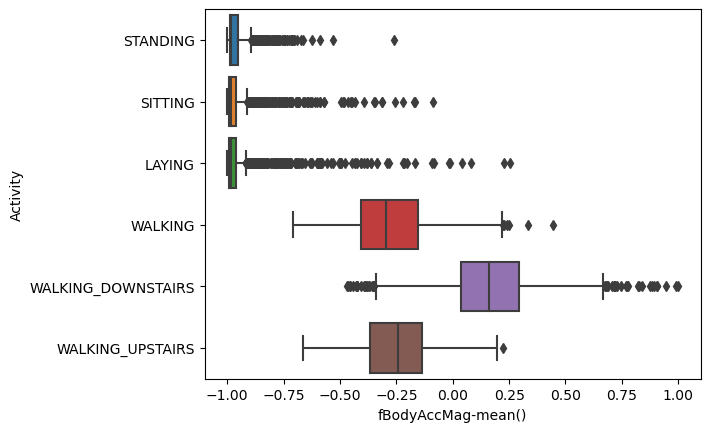

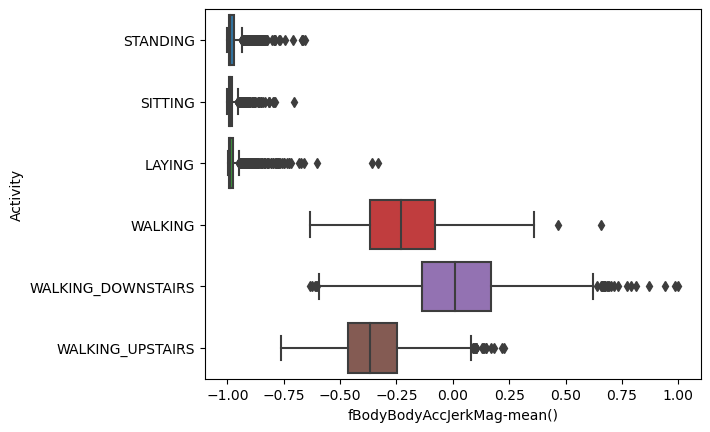

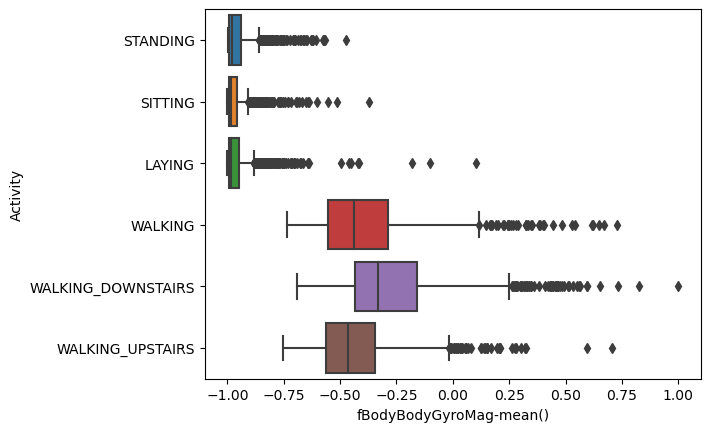

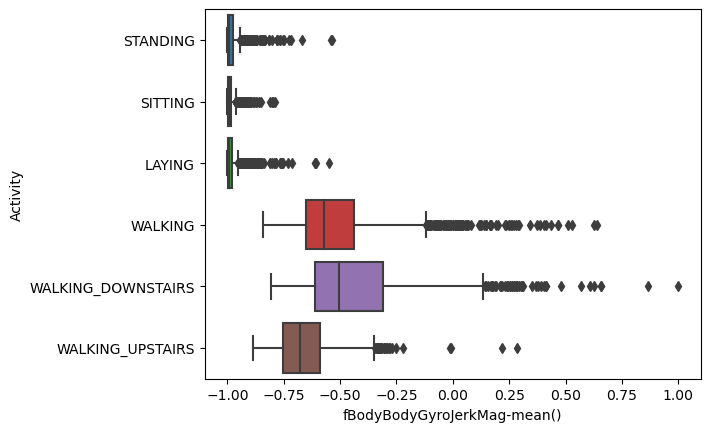

In [65]:
# Create boxplots of magnitude of 3-Dimensional signals and magnitude of frequency domain signals.
categories = ['tBodyAccMag-mean()', 'tGravityAccMag-mean()', 'tBodyAccJerkMag-mean()', 
              'tBodyGyroMag-mean()', 'tBodyGyroJerkMag-mean()', 'fBodyAccMag-mean()', 
              'fBodyBodyAccJerkMag-mean()', 'fBodyBodyGyroMag-mean()', 'fBodyBodyGyroJerkMag-mean()']
for i in categories:
    sns.boxplot(x=i, y='Activity_Name', data=combined_train_data, orient='h')
    plt.ylabel('Activity')
    plt.show()

In [66]:

# Find the mean of each feature grouped by the subject ID and activity name.
dfmean = combined_train_data.groupby(['Subject_ID', 'Activity_Name']).mean()

# Extract subset of columns in categories and assign to variable x
x = dfmean[categories]
print(x.head())

y = dfmean.reset_index()['Activity_Name']
print(y.head())


                               tBodyAccMag-mean()  tGravityAccMag-mean()  \
Subject_ID Activity_Name                                                   
1          LAYING                       -0.841929              -0.841929   
           SITTING                      -0.948537              -0.948537   
           STANDING                     -0.984278              -0.984278   
           WALKING                      -0.136971              -0.136971   
           WALKING_DOWNSTAIRS            0.027188               0.027188   

                               tBodyAccJerkMag-mean()  tBodyGyroMag-mean()  \
Subject_ID Activity_Name                                                     
1          LAYING                           -0.954396            -0.874760   
           SITTING                          -0.987364            -0.930892   
           STANDING                         -0.992368            -0.976494   
           WALKING                          -0.141429            -0.160980   

In [67]:
# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create svm.SVC object and assign to variable svm.
svm = svm.SVC()

# Fit SVM on training data
svm.fit(x_train_scaled, y_train)

# Predict with input of testing data and assign the result to variable predictions1.
predictions1 = svm.predict(x_test_scaled)

# Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
score1 = accuracy_score(y_test, predictions1)

# Print accuracy score. 
print('Accuracy score for Support Vector Machine:', score1)


Accuracy score for Support Vector Machine: 0.4375


In [68]:
from sklearn import svm
import random
svm = svm.SVC()
import heapq
max_heap = []

def setXandY():
  for i in range(9000):
    column_names = np.array(combined_train_data.columns)[3:]
    random.seed(i)
    selected_columns = random.sample(column_names.tolist(), k=random.randint(1, 9))
    x = dfmean[selected_columns]
    # Split x and y into training and testing sets with seed 0.
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

    # Apply StandardScaler to x_train and x_test
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Create svm.SVC object and assign to variable svm.
    

    # Fit SVM on training data
    svm.fit(x_train_scaled, y_train)
    # Predict with input of testing data and assign the result to variable predictions1.
    predictions1 = svm.predict(x_test_scaled)

    # Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
    score1 = accuracy_score(y_test, predictions1)

    # Print accuracy score. 
    heapq.heappush(max_heap, [score1, selected_columns])
    # print(max_heap)
    # print('Accuracy score for Support Vector Machine:', score1)
  return heapq.nlargest(10, max_heap)

In [69]:
temp = setXandY()
for i in temp:
  print(i[0])
  print(i[1])


0.9375
['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)', 'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y']
0.9375
['tBodyAcc-sma()', 'fBodyAcc-bandsEnergy()-1,8', 'fBodyAccJerk-bandsEnergy()-33,40', 'tBodyAcc-mean()-Y', 'tGravityAcc-min()-X', 'tGravityAcc-mean()-Y', 'tBodyAccJerk-arCoeff()-X,1']
0.9375
['fBodyAccJerk-skewness()-Y', 'fBodyAccJerk-std()-Z', 'tGravityAcc-mean()-Y', 'tGravityAccMag-mad()', 'fBodyAcc-std()-X', 'tBodyAccJerk-mean()-Y', 'tBodyGyroJerk-max()-Z']
0.90625
['tGravityAcc-mean()-Y', 'fBodyAcc-mad()-X', 'fBodyAcc-kurtosis()-X', 'fBodyAcc-mean()-Z', 'fBodyAcc-max()-Y', 'fBodyBodyAccJerkMag-kurtosis()', 'tGravityAcc-max()-X', 'fBodyBodyGyroJerkMag-max()', 'tBodyGyro-entropy()-Z']
0.90625
['tGravityAcc-arCoeff()-X,2', 'fBodyGyro-meanFreq()-X', 'tBodyAccJerkMag-max()', 'angle(X,gravityMean)', 'tGravityAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,1', 'fBodyGyro-bandsEnergy()-1,8', 'tGravityAcc-std()-Y']
0.90625
['tBody

In [70]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import random
from sklearn import svm
svm = svm.SVC()
import heapq
max_heap_one = []

# Load your DataFrame 'df' here



results = []

def treeClassifier():
    for i in range(250):
    # Step 1: Randomly select subset of features
        column_names = np.array(combined_train_data.columns)[3:]
        random.seed(i)
        selected_columns = random.sample(column_names.tolist(), k=random.randint(1, 20))
        X = dfmean[selected_columns]
        
        # Step 2: Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Step 3: Define model and hyperparameters
        tree = DecisionTreeClassifier()
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
        
        # Step 4: Perform randomized search with cross-validation
        search = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5)
        search.fit(X_train, y_train)
        
        # Step 5: Evaluate best model on test set
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        heapq.heappush(max_heap_one, [accuracy, selected_columns])
        
    return heapq.nlargest(10, max_heap_one)

In [71]:
temp = treeClassifier()
for i in temp:
  print(i[0])
  print(i[1])

0.9230769230769231
['fBodyAccJerk-energy()-Z', 'fBodyGyro-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-1,8', 'fBodyAccJerk-mean()-Z', 'angle(X,gravityMean)', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAccJerk-mean()-Z', 'fBodyAcc-entropy()-Y', 'fBodyAcc-std()-Z', 'fBodyAcc-maxInds-Z', 'tGravityAccMag-arCoeff()2', 'tBodyAcc-mad()-X', 'fBodyAccJerk-bandsEnergy()-33,40', 'fBodyBodyAccJerkMag-mean()', 'fBodyGyro-max()-Y', 'tBodyGyroJerk-mean()-Z']
0.8846153846153846
['tBodyAccJerk-entropy()-Z', 'tGravityAcc-iqr()-Z', 'fBodyGyro-std()-Z', 'fBodyAcc-bandsEnergy()-57,64', 'fBodyGyro-bandsEnergy()-25,48', 'tGravityAcc-mean()-X', 'tGravityAcc-arCoeff()-X,1', 'tBodyAccJerk-arCoeff()-Z,4']
0.8846153846153846
['fBodyGyro-energy()-X', 'fBodyBodyGyroMag-kurtosis()', 'tGravityAcc-entropy()-X', 'fBodyGyro-iqr()-Y', 'fBodyAccMag-sma()', 'tBodyAccMag-energy()', 'fBodyGyro-max()-X', 'tBodyGyro-entropy()-Y', 'tBodyGyroJerk-max()-Y', 'fBodyAccMag-entropy()', 'tGravityAcc-mad()-Y', 'tBodyGyroJerk-mad()-Y', 'tGravityA

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np  # Make sure numpy is imported

# Assuming your data is already scaled and split into x_train_scaled, x_test_scaled, y_train, and y_test

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(x_train_scaled))) # This is a suggested starting point, feel free to adjust it

# Instantiate the KNN model with the calculated number of neighbors
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the KNN model to your scaled training data
knn.fit(x_train_scaled, y_train)

# Use the fitted model to make predictions on your test data
knn_predictions = knn.predict(x_test_scaled)

# Evaluate the KNN model's performance
knn_score = accuracy_score(y_test, knn_predictions)
print('Accuracy score for K-Nearest Neighbors:', knn_score)

# For a more detailed performance analysis, consider using a confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))


Accuracy score for K-Nearest Neighbors: 0.53125
Confusion Matrix:
 [[2 2 2 0 0 0]
 [2 2 1 0 0 0]
 [5 1 3 0 0 0]
 [0 0 0 4 0 1]
 [0 0 0 0 5 1]
 [0 0 0 0 0 1]]
Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.22      0.33      0.27         6
           SITTING       0.40      0.40      0.40         5
          STANDING       0.50      0.33      0.40         9
           WALKING       1.00      0.80      0.89         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.33      1.00      0.50         1

          accuracy                           0.53        32
         macro avg       0.58      0.62      0.56        32
      weighted avg       0.60      0.53      0.55        32



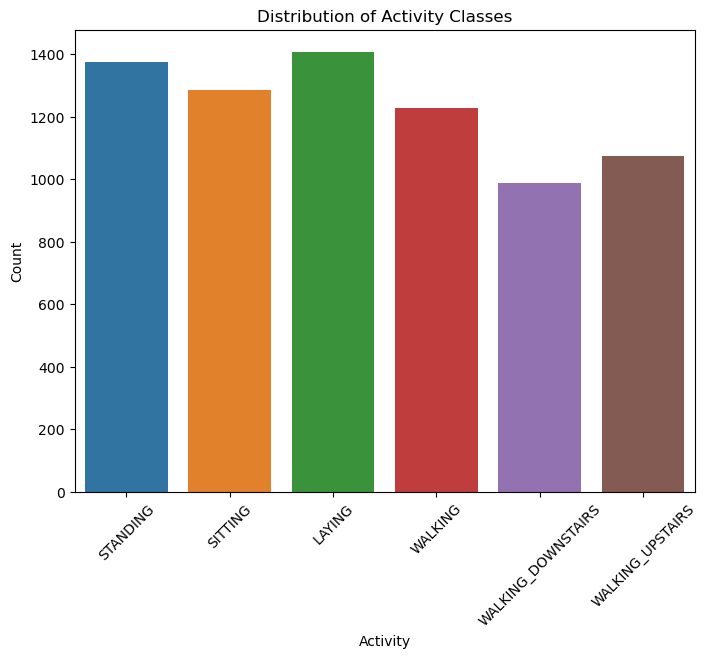

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize distribution of activity classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Activity_Name', data=combined_train_data)
plt.title('Distribution of Activity Classes')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()





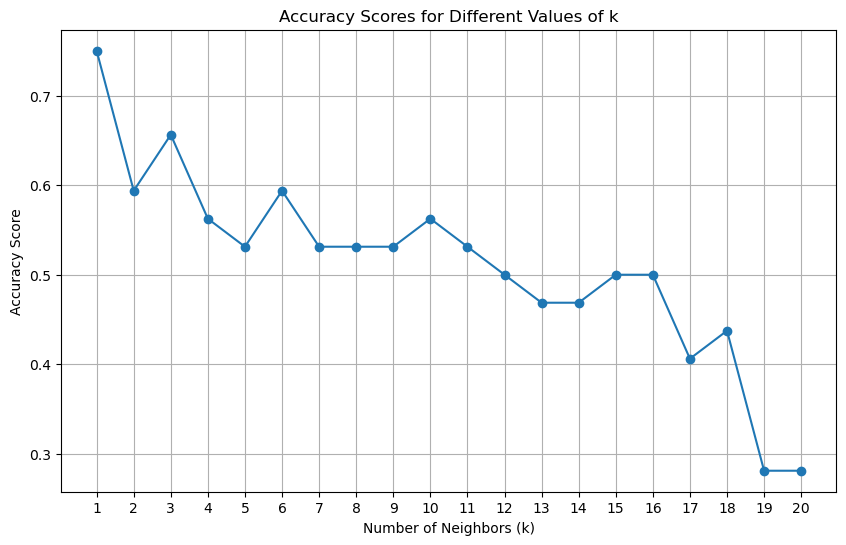

In [74]:
# Visualize accuracy scores for different values of k
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)
    knn_predictions = knn.predict(x_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, knn_predictions))

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Accuracy Scores for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()




In [75]:
# Perform grid search to find optimal hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'n_neighbors': 13, 'weights': 'distance'}
Best cross-validation score: 0.6830409356725146


Shape of xx: (278, 307)
Shape of yy: (278, 307)
Shape of Z: (278, 307)
Unique values in Z: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


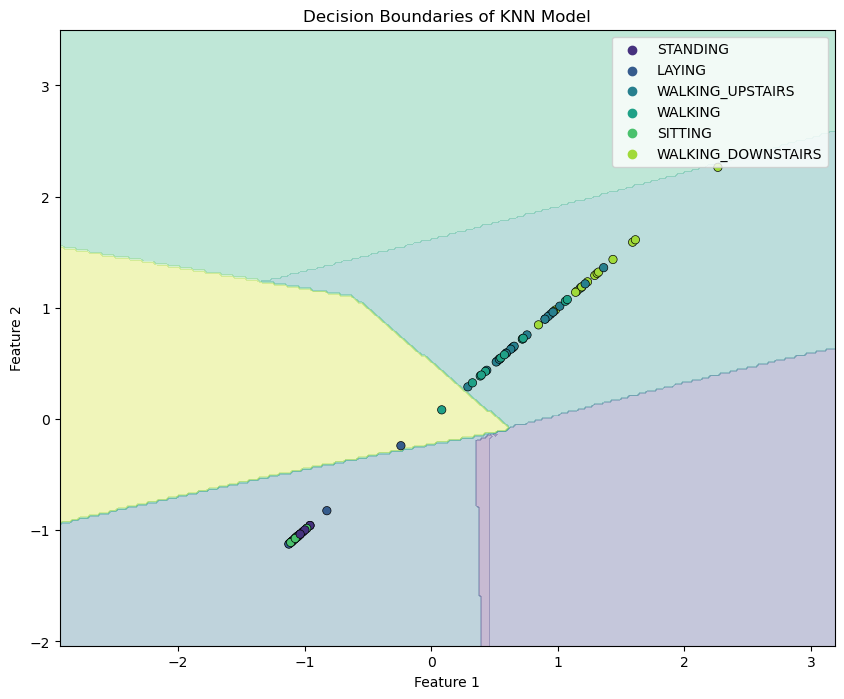

In [76]:
# Visualize decision boundaries in 2D space (assuming only two features are used)
if len(categories) >= 2:
    knn = KNeighborsClassifier(n_neighbors=5)  # Assuming 5 neighbors
    knn.fit(x_train_scaled[:, :2], y_train)

    print("Shape of xx:", xx.shape)
    print("Shape of yy:", yy.shape)
    print("Shape of Z:", Z.shape)
    print("Unique values in Z:", np.unique(Z))

    # Convert Z to numerical values using label encoding
    label_encoder = LabelEncoder()
    Z_encoded = label_encoder.fit_transform(Z.ravel())
    Z_encoded = Z_encoded.reshape(xx.shape)  # Reshape to match xx and yy shapes

    # Plot decision boundaries
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z_encoded, alpha=0.3, cmap='viridis')
    # Plot the training points
    sns.scatterplot(x=x_train_scaled[:, 0], y=x_train_scaled[:, 1], hue=y_train, palette='viridis', edgecolor='black')
    plt.title('Decision Boundaries of KNN Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper right')
    plt.show()




Performance Metrics:
                     Precision    Recall  F1-score
LAYING               0.200000  0.166667  0.181818
SITTING              0.166667  0.400000  0.235294
STANDING             0.333333  0.111111  0.166667
WALKING              1.000000  0.200000  0.333333
WALKING_DOWNSTAIRS   0.666667  0.666667  0.666667
WALKING_UPSTAIRS     0.000000  0.000000  0.000000


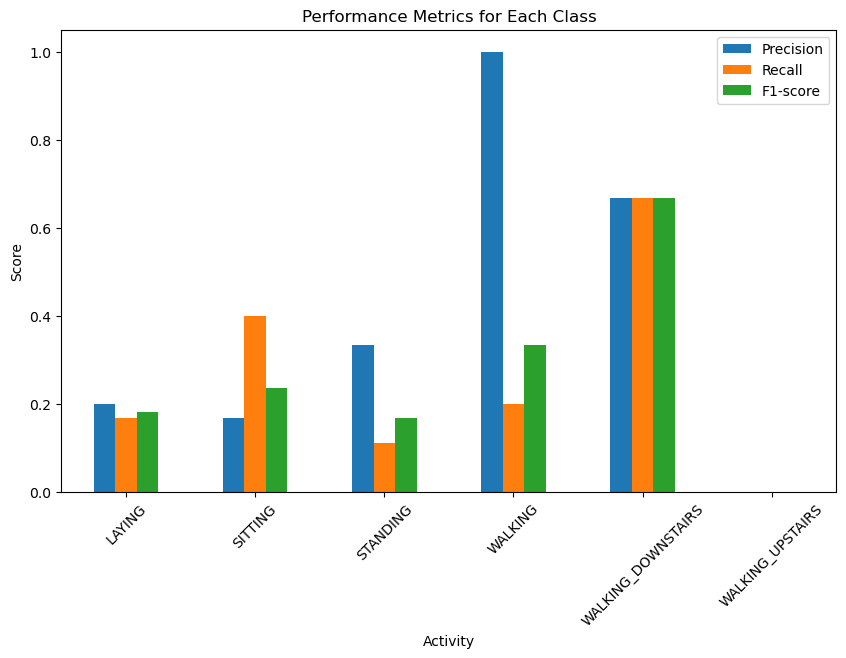

In [77]:
# Visualize performance metrics (precision, recall, F1-score) for each class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, knn_predictions, average=None, labels=np.unique(y_test))
metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-score': f1_score}, index=np.unique(y_test))
print("Performance Metrics:\n", metrics_df)

# Plot performance metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics for Each Class')
plt.xlabel('Activity')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


In [78]:
# Perform cross-validation to evaluate model performance
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn, x_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [0.52631579 0.52631579 0.57894737 0.57894737 0.72222222]
Mean CV Score: 0.5865497076023392


In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np  # Make sure numpy is imported

max_heap = []

def knn_feature_selection():
  for i in range(3000):
    column_names = np.array(combined_train_data.columns)[3:]
    random.seed(i)
    selected_columns = random.sample(column_names.tolist(), k=random.randint(1,20))
    x = dfmean[selected_columns]
    # Split x and y into training and testing sets with seed 0.
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

    # Apply StandardScaler to x_train and x_test
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Calculate the optimal number of neighbors based on your training data size
    n_neighbors = int(np.sqrt(len(x_train_scaled)))
    
    # Instantiate the KNN model with the calculated number of neighbors
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit the KNN model to your scaled training data
    knn.fit(x_train_scaled, y_train)
    
    # Use the fitted model to make predictions on your test data
    knn_predictions = knn.predict(x_test_scaled)

    # Evaluate the KNN model's performance
    knn_score = accuracy_score(y_test, knn_predictions)
    
    # Print accuracy score. 
    heapq.heappush(max_heap, [knn_score, selected_columns])
    # print(max_heap)
    # print('Accuracy score for Support Vector Machine:', score1)
  return heapq.nlargest(10, max_heap)

knn_feature_results = knn_feature_selection()
for i in knn_feature_results:
  print(i[0])
  print(i[1])

0.9375
['tGravityAccMag-std()', 'tBodyGyroJerkMag-sma()', 'fBodyGyro-bandsEnergy()-33,40', 'tBodyAccMag-mean()', 'fBodyAccJerk-bandsEnergy()-1,16', 'tBodyAcc-mad()-X', 'angle(X,gravityMean)', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-std()-Y', 'tBodyAccJerkMag-max()', 'fBodyBodyAccJerkMag-meanFreq()', 'tBodyGyro-entropy()-X', 'fBodyAccJerk-mad()-X']
0.9375
['tBodyGyroJerk-std()-X', 'fBodyAcc-bandsEnergy()-33,48', 'tBodyAcc-mean()-Y', 'fBodyGyro-bandsEnergy()-9,16', 'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccMag-arCoeff()2', 'tBodyAccJerk-min()-X', 'tBodyGyroJerk-mad()-Z', 'fBodyGyro-mad()-Y', 'fBodyGyro-bandsEnergy()-49,56', 'tBodyAccJerk-arCoeff()-X,4', 'fBodyAccJerk-bandsEnergy()-1,24', 'tGravityAcc-arCoeff()-X,1', 'angle(Y,gravityMean)', 'fBodyGyro-maxInds-Z', 'fBodyAcc-energy()-Z', 'tGravityAcc-min()-X', 'fBodyAcc-entropy()-Y', 'fBodyAcc-mad()-X', 'tBodyAcc-mean()-X']
0.9375
['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',

In [80]:
# List of features to be used in KNN
knn_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y',
                'fBodyAcc-bandsEnergy()-33,48', 'tBodyAccMag-max()', 
                'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-57,64',
                'tBodyGyro-mad()-Z', 'fBodyBodyGyroMag-energy()']

# Extract subset of columns in knn_features and assign to variable x_knn
x_knn = dfmean[knn_features]

# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x_knn, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(x_train_scaled)))

# Instantiate the KNN model with the calculated number of neighbors
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the KNN model to your scaled training data
knn.fit(x_train_scaled, y_train)

# Use the fitted model to make predictions on your test data
knn_predictions = knn.predict(x_test_scaled)

# Evaluate the KNN model's performance
knn_score = accuracy_score(y_test, knn_predictions)
print('Accuracy score for K-Nearest Neighbors:', knn_score)

# For a more detailed performance analysis, consider using a confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))

# Perform grid search to find optimal hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Accuracy score for K-Nearest Neighbors: 0.9375
Confusion Matrix:
 [[6 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 1 8 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 5 1]
 [0 0 0 0 0 1]]
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         6
           SITTING       0.83      1.00      0.91         5
          STANDING       1.00      0.89      0.94         9
           WALKING       1.00      1.00      1.00         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.94        32
         macro avg       0.89      0.95      0.90        32
      weighted avg       0.96      0.94      0.94        32

Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.915204678362573


In [87]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn import svm

# List of features to be used in SVM
svm_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y']

# Extract subset of columns in svm_features and assign to variable x_svm
x_svm = dfmean[svm_features]

# Split x and y into training and testing sets with seed 0.
x_train, x_test, y_train, y_test = train_test_split(x_svm, y, random_state=0)

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create svm.SVC object and assign to variable svm.
svm = svm.SVC()

# Fit SVM on training data
svm.fit(x_train_scaled, y_train)

# Predict with input of testing data and assign the result to variable predictions1.
predictions1 = svm.predict(x_test_scaled)

# Calculate the accuracy_score on the y testing data and the test predictions and assign the result to the variable score1.
score1 = accuracy_score(y_test, predictions1)

# Print accuracy score. 
print('Accuracy score for Support Vector Machine:', score1)

# # Define the parameter grid
# param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

# # Create a RandomizedSearchCV instance
# rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
# rnd_search_cv.fit(x_train_scaled, y_train)

# # Get the best parameters and the best score
# print("Best parameters: ", rnd_search_cv.best_params_)
# print("Best score: ", rnd_search_cv.best_score_)

# # Use the best estimator to make predictions
# best_svm = rnd_search_cv.best_estimator_
# predictions2 = best_svm.predict(x_test_scaled)

# # Calculate the accuracy score
# score1 = accuracy_score(y_test, predictions2)
# print('Accuracy score for Support Vector Machine after hyperparameter tuning:', score1)

Accuracy score for Support Vector Machine: 0.9375


Classification Report for SVM Classifier:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         6
           SITTING       0.83      1.00      0.91         5
          STANDING       1.00      0.89      0.94         9
           WALKING       1.00      1.00      1.00         5
WALKING_DOWNSTAIRS       1.00      0.83      0.91         6
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.94        32
         macro avg       0.89      0.95      0.90        32
      weighted avg       0.96      0.94      0.94        32

Confusion Matrix for SVM Classifier:
                     LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
LAYING                   6        0         0        0                   0   
SITTING                  0        5         0        0                   0   
STANDING                 0        1         8        0                   0   
WALK

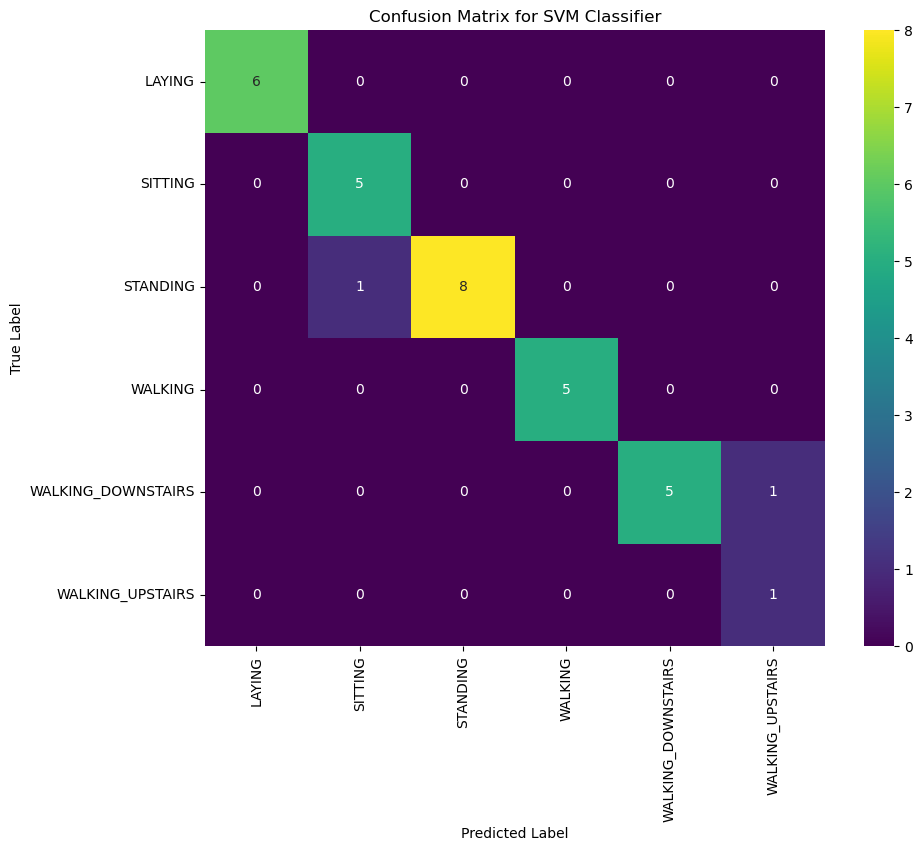

In [89]:
from sklearn.metrics import classification_report

# Create classification report for results of SVM
class_report = classification_report(y_test, predictions1)
print("Classification Report for SVM Classifier:\n", class_report)

# Create confusion matrix for results of SVM classifier
conf_matrix = confusion_matrix(y_test, predictions1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=np.unique(y_test), columns=np.unique(y_test))
print("Confusion Matrix for SVM Classifier:\n", conf_matrix_df)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [83]:
# List of features to be used in Decision Tree
tree_features = ['tBodyAcc-arCoeff()-Y,2', 'fBodyGyro-bandsEnergy()-1,24', 
                 'tBodyGyroJerk-iqr()-Z', 'fBodyGyro-bandsEnergy()-25,48', 
                 'tBodyAcc-mean()-Y', 'fBodyAcc-max()-Y', 'tBodyAcc-min()-X', 
                 'fBodyAccJerk-mad()-Y', 'fBodyAccJerk-bandsEnergy()-1,24', 
                 'tBodyGyroMag-sma()', 'fBodyAcc-max()-X', 'fBodyBodyAccJerkMag-kurtosis()', 
                 'fBodyAccJerk-min()-X', 'fBodyGyro-bandsEnergy()-57,64', 
                 'angle(tBodyGyroMean,gravityMean)', 'tBodyGyroJerk-arCoeff()-Y,1', 
                 'tBodyGyroJerk-mean()-Y']

# Extract subset of columns in tree_features and assign to variable x_tree
x_tree = dfmean[tree_features]

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_tree, y, test_size=0.2, random_state=42)

# Step 3: Define model and hyperparameters
tree = DecisionTreeClassifier()
param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# Step 4: Perform randomized search with cross-validation
search = RandomizedSearchCV(tree, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5)
search.fit(X_train, y_train)

# Step 5: Evaluate best model on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score for Decision Tree:", accuracy)

Accuracy score for Decision Tree: 1.0


In [4]:
# Load test set data
x_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('test/y_test.txt', header=None)
subject_test = pd.read_csv('test/subject_test.txt', header=None)

# Load features and activity labels
features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['Feature_Index', 'Feature_Name'])
activity_labels = pd.read_csv('activity_labels.txt', delim_whitespace=True, header=None, names=['Activity_Index', 'Activity_Name'])

# Set column names for x_test
x_test.columns = features['Feature_Name']

# Set column name for y_test
y_test.columns = ['Activity_Index']

# Set column name for subject_test
subject_test.columns = ['Subject_ID']

# Map activity labels to their corresponding names
y_test['Activity_Name'] = y_test['Activity_Index'].map(activity_labels.set_index('Activity_Index')['Activity_Name'])

# Combine features, labels, and subject IDs
combined_test_data = pd.concat([subject_test, y_test, x_test], axis=1)

# Display the combined data
combined_test_data.drop_duplicates()

x = combined_test_data.drop(columns=["Activity_Name"])

y = combined_test_data['Activity_Name']

# Find the mean of each feature grouped by the subject ID and activity name.
dfmean = combined_test_data.groupby(['Subject_ID', 'Activity_Name']).mean()
y = dfmean.reset_index()['Activity_Name']


In [5]:
# List of features to be used in KNN
knn_features = ['tBodyGyro-arCoeff()-X,1', 'tBodyAccJerkMag-mean()', 
                'tBodyAccJerk-correlation()-Y,Z', 'angle(X,gravityMean)',
                'tGravityAcc-iqr()-Y', 'tBodyAcc-mean()-Y',
                'fBodyAcc-bandsEnergy()-33,48', 'tBodyAccMag-max()', 
                'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-57,64',
                'tBodyGyro-mad()-Z', 'fBodyBodyGyroMag-energy()']

# Extract subset of columns in knn_features and assign to variable x_knn
x_knn = dfmean[knn_features]

# Apply StandardScaler to x_train and x_test
scaler = StandardScaler()
scaler.fit(x_knn)
x_test_scaled = scaler.transform(x_knn)

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(x_test_scaled)))

# Instantiate the KNN model with the calculated number of neighbors
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the KNN model to your scaled training data
knn.fit(x_test_scaled, y)

# Use the fitted model to make predictions on your test data
knn_predictions = knn.predict(x_test_scaled)

# Evaluate the KNN model's performance
knn_score = accuracy_score(y, knn_predictions)
print('Accuracy score for K-Nearest Neighbors:', knn_score)

# For a more detailed performance analysis, consider using a confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y, knn_predictions))
print("Classification Report:\n", classification_report(y, knn_predictions))

NameError: name 'KNeighborsClassifier' is not defined